In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import fsvpy as fsv
import pandas as pd
from pandas import DataFrame, Series
from scipy.optimize import curve_fit
import os.path
from scipy.optimize import OptimizeWarning
import warnings

In [2]:
#catch optimize error warnings
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)

In [3]:
@pims.pipeline
def conv_grey(frame):
    one_channel = frame[:,:,1]
    return one_channel

#change tiff stack here ------>
frames = pims.open('D:/Lab_Data_Akalanka/2024_03_27/Flow_center/*.tif')

singleFrame =False
needplot = False
frame = 654 #frame to show

if needplot ==True:
    plt.imshow(frames[frame], cmap = 'Greys_r')
#frames= frames[13]

In [4]:
#define arrays to store var

temp =[] #stores width
temp_h=[] # stores height
centerx = []
centery =[]



In [5]:

#frames.shape[0]----- copy this in for loop for many frames i. e. singleFrame = False
# (frame,frame+1,1) ---- copy this in loop for a single frame i.e. singleFrame = True
for j in range(frames.shape[0]):

    if j%100 ==0:
        print(f'{j}processes completed....')

    
    image = frames[j]    
    contours, preprocessed_img = fsv.locate_streaks(image)
    #Now .locate streaks does the preprocess step, detects contours and returns it!   
    streak_properties = fsv.parameters(contours)
    # .parameters analyzes the contours detected, checks for the closed contours, and returns a PD containing contour properties( area, angle etc)
    streak_properties= streak_properties.dropna()
    # drops any NaN's in the dataframe
    filtered_streaks= fsv.filter(streak_properties)
    # .filter enforces min_height, min_aspect ratio and an edge filter to remove unwanted streaks
    # returns the filtered data frame
    filtered_streaks=filtered_streaks.dropna()
    # just a caution- drops any Nan's
    fitted_streaks= fsv.fit_shape(image, filtered_streaks)
    # extract the width, height of the streaks by fitting to gaussians!
    # This will work ok for in-plane streaks
    # Need another way to fit for off-plane streaks, as they necessarily don't follow gaussian profiles'
    # Returns the final pandas dataframe with all the streak parameters

    if len(np.asarray(fitted_streaks['width'])) !=0:
        temp.append(np.asarray(fitted_streaks['width']))
        temp_h.append(np.asarray(fitted_streaks['height']))
        centerx.append(np.asarray(fitted_streaks['x']))
        centery.append(np.asarray(fitted_streaks['y']))
        #add centers of the streak


    else:
        pass

 

0processes completed....
 Detected an open contour
 Detected an open contour
Entered except block (bad fit)- measure.py_line 183
 except block measure.py- line 174
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit)- measure.py_line 183
 except block measure.py- line 174
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit)- measure.py_line 183
 Detected an open contour
 Detected an open contour
Optimization warning- measure.py_line 319
Entered except block (bad fit) - measure.py_line 178
 Detected an open contour
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit) - measure.py_line 178
Optimization warning- measure.py_line 319
Optimization warning- measure.py_line 319
Entered except block (bad fit) - measure.py_line 178
 Detected an open contour
 Detected an open contour
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit)- measure.py_line 183
 Detected an open 

In [6]:
if singleFrame:
    # We need to look at athe original contours detected in the frame
    fsv.plot_contours(frames[frame],contours)
    fig, ax = plt.subplots()
    ax.imshow(preprocessed_img, cmap='Greys_r')
    ax.set_title('Pre-processed image');

    # fit and plot the streaks
    fsv.plot_fit(image, fitted_streaks)


In [7]:
#Input imaging parameters
Resl = 325 # nm per pixel (20x with 1x)
Exposure = 90 # in ms
Flow_rate = 60 # in uLpermin

#Filter out the NaN's coming from null tags
true_width = []
true_height= []
true_centerx = []
true_centery = []
#convert from list to array
for iter in range(len(temp)):
    for i in range(int(temp[iter].shape[0])):
         true_width.append(temp[iter][i])
         true_height.append(temp_h[iter][i])
         true_centerx.append(centerx[iter][i])
         true_centery.append(centery[iter][i])

#scale widths by resolution        
true_width = np.asarray(true_width)* (Resl/((Exposure/1000)))/1000000 # in mm/s i.e the velocity
true_height = np.asarray(true_height)* (Resl/1000) #in um, basically should equal particle diameter 
true_centerx = np.asarray(true_centerx)* (Resl/1000)
true_centery = np.asarray(true_centery)* (Resl/1000)


Text(0, 0.5, 'Count')

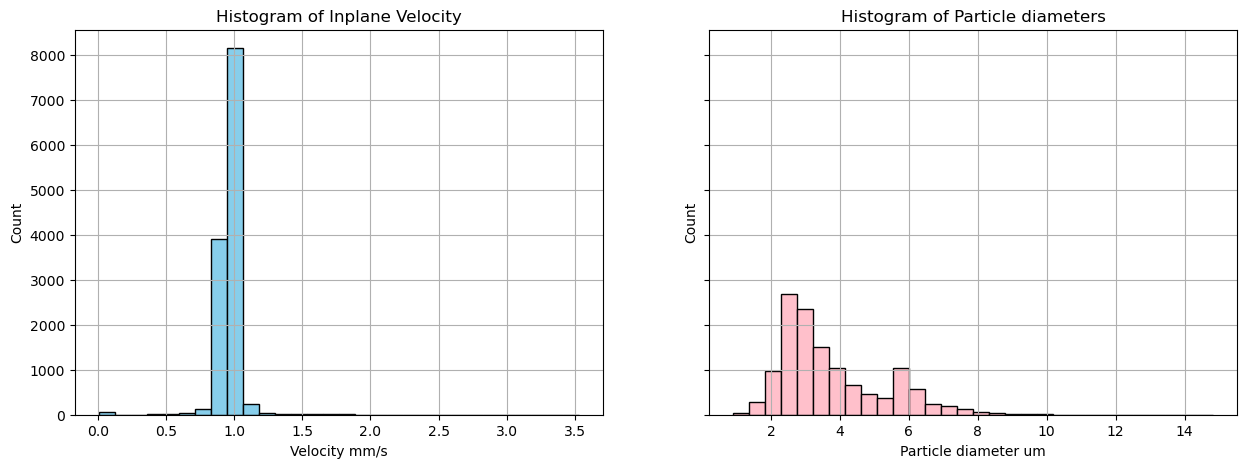

In [8]:

fig, ax = plt.subplots(ncols=2, sharey = True, figsize=(15,5))
ax[0].hist(true_width, bins=30, color='skyblue', edgecolor='black');
ax[0].set_title('Histogram of Inplane Velocity')
ax[0].set_xlabel('Velocity mm/s')
ax[0].set_ylabel('Count')
#ax[0].set_xlim([0.12, 0.16])
ax[0].grid()

ax[1].hist(true_height, bins=30, color='pink', edgecolor='black');
ax[1].set_title('Histogram of Particle diameters')
ax[1].grid()
ax[1].set_xlabel('Particle diameter um')
ax[1].set_ylabel('Count')


Now just proceed to plot the vector fields...

In [9]:
# average rows 
# i.e. if upper left corner is (0,0) & down is X, right is Y
# average all Y in a particular x

Real_FOV  = 2048 * (Resl/1000)  # 2048 is image size mostly fixed for camera
binsize = 20 # um values

d = {'x': true_centerx, 'y': true_centery, 'velocity': true_width, 'diameter': true_height}


all_properties = pd.DataFrame(data = d)


# sort data frame ascending in x
all_properties = all_properties.sort_values(by='x', ascending=True)


Plot the velocity field as a interpolation

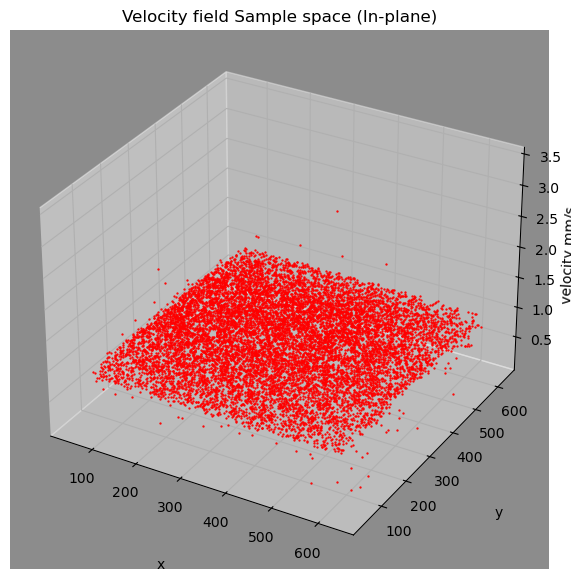

In [10]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
#create mesh
X1, Y1 = np.meshgrid(true_centerx,true_centery)


ax.plot3D(true_centerx, true_centery, true_width,'r.',markersize=1.3)
ax.set_title('Velocity field Sample space (In-plane)')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('velocity mm/s', labelpad=1)
ax.set_facecolor('#8c8c8c')
plt.show()


Averaging is not the best option to plot velocity (?)

In [11]:
# Average velocities according to bin size = []
vx = []
xpos=[]
precision = 1 # um steps size for vector plot

for i in range(0,int(Real_FOV),binsize):
    start = i
    end = (i + binsize)

    df_1 = all_properties[(all_properties['x'] >= start) & (all_properties['x'] <= end)]

    if (df_1.empty):
        #d_2 = {'x': np.linspace(start,end,binsize+1), 'velocity':  np.zeros(binsize+1)}
        x = np.linspace(start,end,binsize+1)
        velocity = np.zeros(binsize+1)
    else:
        
        xmean  = df_1['velocity'].mean()
        x = np.linspace(start,end,binsize+1)
        velocity =  xmean * np.ones(binsize+1)
        #d_2 = {'x': np.linspace(start,end,binsize+1), 'velocity': xmean * np.ones(binsize+1)}
    
    #append to final df
    #df_2 = pd.DataFrame(data = d_2)
    for j in range(binsize):
        vx.append(velocity[j])
        xpos.append(x[j])

    d2 = {'x': xpos, 'velocity': vx}
    velocityfield = pd.DataFrame(data = d2)




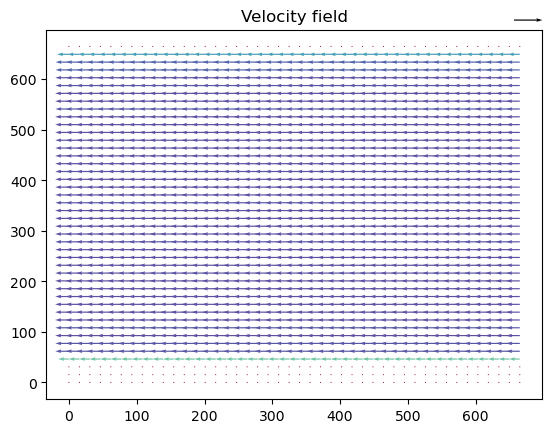

In [12]:
#plot the vector field / Quiver plot
#create a meshgrid
scale=15
X, Y = np.meshgrid(np.linspace(0, int(Real_FOV),int(Real_FOV/scale) ), np.linspace(0, int(Real_FOV),int(Real_FOV/scale) ))

U = np.zeros([int(Real_FOV/scale),int(Real_FOV/scale)])
for i in range(0,int(Real_FOV/scale)-1,1):
    U[i,:] = vx[i*scale]+ U[i,:]

V = np.zeros([int(Real_FOV/scale),int(Real_FOV/scale)])
fig1, ax1 = plt.subplots()
ax1.set_title('Velocity field')
Q = ax1.quiver(X, Y, -U,V,U,cmap="Spectral", scale=35, units='width')
qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
